In [1]:
import geopandas as gp
from shapely import wkt
import pandas as pd
import pprint
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px #if using plotly

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#worldmap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
#usa = gp.read_file("data/cb_2018_us_nation_5m.shp")
us_states = gp.read_file("data/cb_2018_us_state_500k.shp")
ca_state = gp.read_file("/Users/natebender/Desktop/repo/capstone_rmi/data/CA_State_TIGER2016.shp")
ca_counties = gp.read_file("/Users/natebender/Desktop/repo/capstone_rmi/data/CA_Counties_TIGER2016.shp")

In [62]:
# CA social vulnerability data at level of census tract
# source: https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-40
ca_socialdata = gp.read_file("data/CES4 Final Shapefile.shp")

#### a bunch of rows are loading in with -999 CIscore. Not sure why. Removing for now. 

In [71]:
print(len(ca_socialdata[ca_socialdata['CIscore']==-999]))
temp = ca_socialdata[ca_socialdata["CIscore"]!=-999]

103


In [73]:
temp.head(3)

,Tract,ZIP,County,ApproxLoc,TotPop19,CIscore,CIscoreP,Ozone,OzoneP,PM2_5,PM2_5_P,DieselPM,DieselPM_P,Pesticide,PesticideP,Tox_Rel,Tox_Rel_P,Traffic,TrafficP,DrinkWat,DrinkWatP,Lead,Lead_P,Cleanup,CleanupP,GWThreat,GWThreatP,HazWaste,HazWasteP,ImpWatBod,ImpWatBodP,SolWaste,SolWasteP,PollBurd,PolBurdSc,PolBurdP,Asthma,AsthmaP,LowBirtWt,LowBirWP,Cardiovas,CardiovasP,Educatn,EducatP,Ling_Isol,Ling_IsolP,Poverty,PovertyP,Unempl,UnemplP,HousBurd,HousBurdP,PopChar,PopCharSc,PopCharP,Child_10,Pop_10_64,Elderly65,Hispanic,White,AfricanAm,NativeAm,OtherMult,Shape_Leng,Shape_Area,AAPI,geometry
0,6.083002e+09,93454,Santa Barbara,Santa Maria,4495,36.019653,69.162885,0.034190,10.566273,7.567724,10.031114,0.154573,52.408214,1705.217020,92.034483,13.685390,9.914979,1089.731518,63.40,246.372671,11.165230,39.310558,36.118463,1.0,17.077268,73.15,94.720239,0.440,64.765056,9.0,77.299454,0.0,0.000000,40.727364,4.972803,45.003111,82.18,86.652542,6.01,75.327175,12.69,52.006481,30.4,80.663123,18.2,83.840845,57.5,89.660804,3.1,18.310776,21.6,69.150824,69.827003,7.243330,79.828543,18.4427,69.0545,12.5028,68.9210,20.8899,0.4004,0.267,1.3126,6999.357689,2.847611e+06,8.2091,"POLYGON ((-39795.070 -341919.191, -38126.384 -..."
1,6.083002e+09,93455,Santa Barbara,Santa Maria,13173,37.030667,70.637922,0.035217,11.561917,7.624775,10.454263,0.106088,39.365277,31524.113220,99.586207,14.766173,10.265066,486.037849,19.90,441.058741,52.828775,44.641994,43.805923,13.5,72.396417,304.00,99.767558,2.800,95.552614,10.0,82.969341,18.0,97.640321,53.869036,6.577399,79.962663,48.80,54.798106,4.00,26.635874,7.60,10.817547,44.0,92.875221,18.2,83.840845,51.0,83.040201,7.2,69.130661,19.3,60.101394,54.274087,5.629987,56.555724,19.6462,75.0019,5.3519,78.6229,13.2240,2.5051,0.000,0.9489,19100.578232,1.635292e+07,4.6990,"POLYGON ((-39795.070 -341919.191, -39803.632 -..."
2,6.083002e+09,93454,Santa Barbara,Santa Maria,2398,31.213140,61.069087,0.034190,10.566273,7.548835,9.931549,0.190474,60.311139,2328.797488,93.827586,16.020654,10.515129,779.381302,42.75,246.372671,11.165230,66.738056,75.072464,0.1,2.071669,7.50,39.448780,0.135,23.719391,9.0,77.299454,4.0,70.423826,40.375822,4.929880,43.858121,82.18,86.652542,4.95,51.013600,12.69,52.006481,30.2,80.460643,13.3,72.256056,29.4,52.876884,4.3,35.020822,17.9,53.624842,61.036029,6.331420,67.183560,15.0959,72.0183,12.8857,65.7214,30.6088,0.9591,0.000,2.1685,4970.985897,1.352329e+06,0.5421,"POLYGON ((-38115.747 -341130.248, -38126.384 -..."


In [11]:
# set common crs for project
projcrs = 4326
us_states = us_states.to_crs(projcrs)  # match us_states common crs for project
#worldmap = worldmap.to_crs(projcrs)
ca_state = ca_state.to_crs(projcrs)
ca_counties = ca_counties.to_crs(projcrs)

### Functions

In [12]:
def read_excel(sheet_name):
    
    all_files = glob.glob("data/*.xlsx")
    temp = []

    for filename in all_files:
        df = pd.read_excel(filename, index_col=None, header=0, sheet_name=sheet_name)
        temp.append(df)

    df = pd.concat(temp, axis=0, ignore_index=True)

    # some data cleanup
    df.rename(columns={'BCM 2019':'BCM_2019', 'Avg. temp':'avg_temp',
                       'BCM 2018':'BCM_2018', 'BCM 2020':'BCM_2020',
                       'BCM 2021':'BCM_2021',
                       'Detection frequency 2018':'Detection_frequency_2018',
                       'Detection frequency 2020':'Detection_frequency_2020',
                       'Detection frequency 2021':'Detection_frequency_2021',
                       'Clear obs 2018': 'Clear_obs_2018'}, inplace=True)
    
    df["flare_category"] = sheet_name  # add new column for overall flare type, to make summary stats easier
    
    return(df)

In [13]:
def convert_geopandas(df):
    '''Convert pandas df to geodataframe, drop orig Lat/Long cols, and set crs to common project crs'''
    
    df = gp.GeoDataFrame(
        df, geometry=gp.points_from_xy(df["Longitude"],
                                       df["Latitude"]), 
        crs = projcrs)

    df.drop(['Latitude', 'Longitude'], axis=1, inplace=True) 
    return(df)

In [14]:
# define sheet names
all_upstream="flares_upstream"
oil_downstream="flares_oil_downstream"
gas_downstream="flares_gas_downstream"

# create dfs by flare category
flares_upstream = read_excel(all_upstream)
oil_downstream = read_excel(oil_downstream)
gas_downstream = read_excel(gas_downstream)

# combine into single df and convert to geodataframe
all_flares = convert_geopandas(pd.concat([flares_upstream, oil_downstream, gas_downstream]))

/Users/natebender/opt/anaconda3/envs/capstonermi37/lib/python3.7/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [128]:
# subset to just lower 48 plus AK
# remove territories (PR, PW, VI, MH, GU) and AK, HI
stateslist = ["AL","AR","AZ","CA","CO","CT","DC","DE","FL","GA","IA","ID", "IL","IN","KS","KY","LA","MA","MD","ME","MI","MN","MO","MS","MT","NC","ND","NE","NH","NJ","NM","NV","NY", "OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VA","VT","WA","WI","WV","WY"]
us_states = us_states[us_states['STUSPS'].isin(stateslist)]

# match all flares with just CA counties
inner_join_result = gp.sjoin(all_flares, ca_counties, how = "inner", op = 'within')
#print(f'Flares found: {len(inner_join_result)}')

col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

inner_join_result['BCM_avg'] = inner_join_result[col_list].mean(axis=1)  # grab avg BCM across all years

In [24]:
inner_join_result.head(3)

,Country,ISO Code,Catalog ID,id #,BCM_2019,avg_temp,Ellipticity,Detection_frequency_2019,Clear_obs_2019,Type,ID 2020,BCM_2020,"Avg. temp., K",Detection_frequency_2020,Clear_obs_2020,ID 2021,BCM_2021,Detection_frequency_2021,Clear_obs_2021,id_key_2017,Avg_Temp_K,Detection_frequency_2017,Clear_obs_2017,ISO_Code,BCM_2017,id_key,BCM_2012,BCM_2013,BCM_2014,BCM_2015,BCM_2016,Clear_obs_2012,Clear_obs_2013,Clear_obs_2014,Clear_obs_2015,Clear_obs_2016,Detection_frequency_2012,Detection_frequency_2013,Detection_frequency_2014,Detection_frequency_2015,Detection_frequency_2016,Catalog id,BCM_2018,Detection_frequency_2018,Clear_obs_2018,flare_category,Detection freq.,Clear obs.,Clear Obs.,geometry,index_right,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,BCM_avg
3359,United States,USA,USA_UPS_2015_118.8924W_34.4787N_v0.2,1010.0,0.006512,1896.56,1.62683,20.3343,359.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flares_upstream,NaN,NaN,NaN,POINT (-118.89241 34.47866),4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,0.006512
5356,United States,USA,USA_UPS_2015_119.4557W_34.3722N_v0.2,1003.0,0.001944,1790.00,1.70278,11.6788,274.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flares_upstream,NaN,NaN,NaN,POINT (-119.45572 34.37218),4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,0.001944
5617,United States,USA,USA_UPS_2015_118.7840W_34.3740N_v0.2,1012.0,0.001616,1822.63,1.60150,14.8045,358.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flares_upstream,NaN,NaN,NaN,POINT (-118.78400 34.37402),4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,0.001616


#### to do: figure out how to show axis of second plot (flares) as well

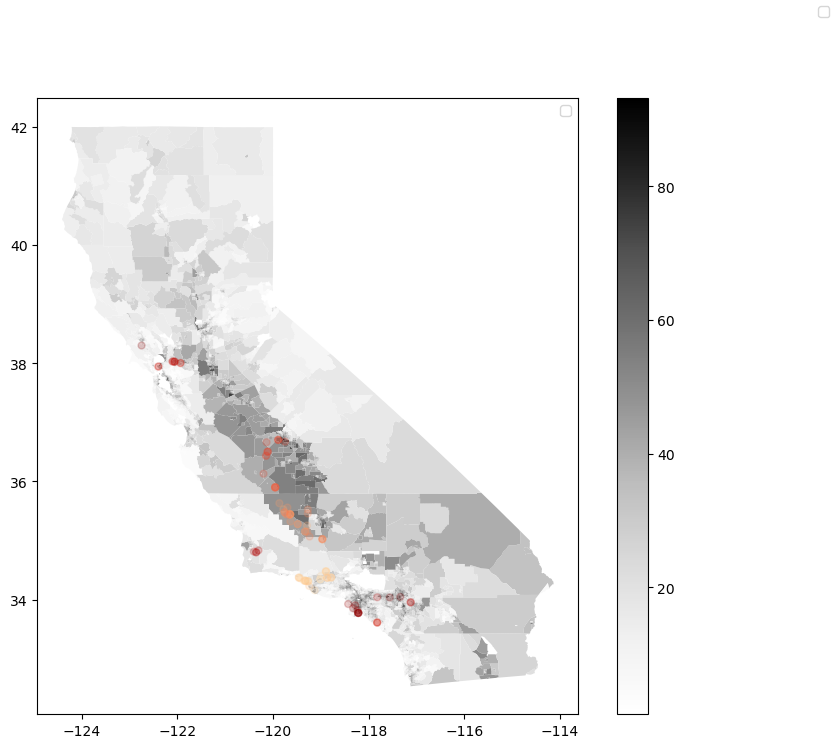

In [92]:
fig, ax = plt.subplots(figsize=(10,8))
fig1=temp.to_crs(inner_join_result.crs).plot(ax=ax, column='CIscore', cmap='Greys', legend=True)
fig2=inner_join_result.plot(ax = ax, facecolors='none', cmap="OrRd", alpha=.2, markersize=25, legend=True)
#labels = ["CIscore", "Methane Flares"]
#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')
fig.legend(handles, labels, loc='upper right')
fig2.legend(handles, labels, loc='upper right')
plt.show()

### Buffers

#### to do: double check crs system that buffers are being correctly specified in units of meters

In [129]:
temp_flares = inner_join_result.to_crs(epsg=3310)
# temp_flares['geometry'].isna().sum()

In [177]:
# create buffers at 1000 meters radius around points
temp_flares['geom_buff1000'] = temp_flares['geometry'].buffer(1000)
temp_flares['geom_buff5000'] = temp_flares['geometry'].buffer(5000)

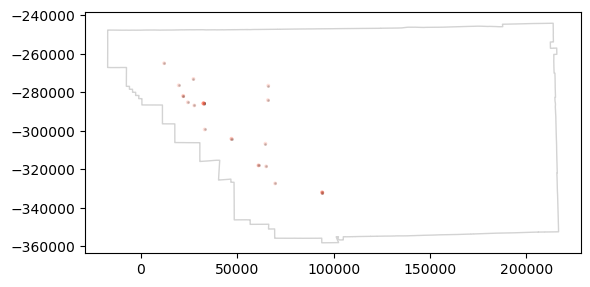

In [178]:
# plot Kern county as example
kern = ca_counties[ca_counties['NAME']=='Kern']
kern = kern.to_crs(temp_flares.crs)
result = gp.sjoin(temp_flares, kern, how = "inner", op = 'within')

fig, ax = plt.subplots()
kern.plot(ax=ax, color='white', edgecolor="lightgrey", legend=True)
result['geometry'].plot(ax = ax, facecolors='grey', color="black", alpha=.2, markersize=1)
result['geom_buff1000'].plot(ax = ax, facecolors='none', color="tomato", alpha=.2, markersize=1)
plt.show()

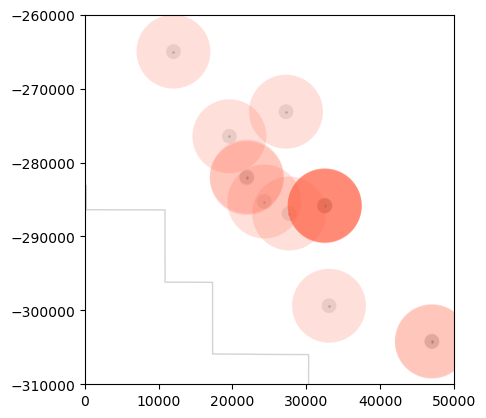

In [182]:
# zoom a bit

fig, ax = plt.subplots()
kern.plot(ax=ax, color='white', edgecolor="lightgrey", legend=True)
result['geometry'].plot(ax = ax, facecolors='grey', color="black", alpha=.2, markersize=1)
result['geom_buff1000'].plot(ax = ax, facecolors='none', color="grey", alpha=.2, markersize=1)
result['geom_buff5000'].plot(ax = ax, facecolors='none', color="tomato", alpha=.2, markersize=1)
ax.set_xlim(0,50000)
ax.set_ylim(-310000,-260000)
plt.show()

### Makeup of Kern county intersected with flare buffers

In [202]:
kern

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
32,06,029,02054176,06029,Kern,Kern County,06,H1,G4020,None,12540,None,A,21061589620,79574760,+35.3466288,-118.7295064,"POLYGON ((7829.961 -286403.897, 6958.062 -2864..."


In [203]:
kern_socialdata = gp.overlay(kern, ca_socialdata, how = "intersection")

In [204]:
len(kern_socialdata)

167

In [205]:
kern_socialdata

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Tract,ZIP,County,ApproxLoc,TotPop19,CIscore,CIscoreP,Ozone,OzoneP,PM2_5,PM2_5_P,DieselPM,DieselPM_P,Pesticide,PesticideP,Tox_Rel,Tox_Rel_P,Traffic,TrafficP,DrinkWat,DrinkWatP,Lead,Lead_P,Cleanup,CleanupP,GWThreat,GWThreatP,HazWaste,HazWasteP,ImpWatBod,ImpWatBodP,SolWaste,SolWasteP,PollBurd,PolBurdSc,PolBurdP,Asthma,AsthmaP,LowBirtWt,LowBirWP,Cardiovas,CardiovasP,Educatn,EducatP,Ling_Isol,Ling_IsolP,Poverty,PovertyP,Unempl,UnemplP,HousBurd,HousBurdP,PopChar,PopCharSc,PopCharP,Child_10,Pop_10_64,Elderly65,Hispanic,White,AfricanAm,NativeAm,OtherMult,Shape_Leng,Shape_Area,AAPI,geometry
0,06,029,02054176,06029,Kern,Kern County,06,H1,G4020,None,12540,None,A,21061589620,79574760,+35.3466288,-118.7295064,6.083002e+09,32,Santa Barbara,Unincorporated Santa Barbara County area,1050,22.281902,42.713061,0.048278,55.382701,5.783726,2.650902,0.000970,0.336030,237.994763,81.448276,5.133914,7.526882,98.971321,1.0750,654.335216,72.111902,77.389354,86.956522,0.00,0.000000,64.55,93.358791,0.200,35.618795,8.0,72.154557,10.0,91.042383,45.102320,5.506984,56.950840,26.14,18.531904,2.63,5.568386,8.98,20.862413,18.3,61.807137,20.2,86.899445,38.5,66.871859,9.3,83.224883,10.6,16.311787,39.005295,4.046117,33.862834,16.8571,62.0952,21.0476,45.6190,50.0952,0.5714,0.7619,1.5238,332178.528527,3.024585e+09,1.4286,"POLYGON ((50647.742 -346001.694, 50411.928 -34..."
1,06,029,02054176,06029,Kern,Kern County,06,H1,G4020,None,12540,None,A,21061589620,79574760,+35.3466288,-118.7295064,6.029002e+09,93309,Kern,Bakersfield,5613,30.272314,59.253656,0.064647,93.627878,15.558801,99.502178,0.033477,11.947729,0.000000,0.000000,118.460167,25.356339,1428.671653,76.2500,558.112624,65.280380,26.952412,20.352867,0.90,11.832773,0.00,0.000000,0.450,65.916612,0.0,0.000000,0.0,0.000000,37.876407,4.624702,37.013068,81.79,86.453141,5.42,62.612266,17.62,79.150050,9.8,41.230068,0.8,4.587901,37.2,64.899497,8.2,76.691827,20.1,63.257288,63.102568,6.545787,70.284922,14.8049,75.7349,9.4602,32.7276,49.2250,8.4447,0.0000,4.4896,12653.176612,4.995807e+06,5.1131,"POLYGON ((85530.318 -294415.802, 85381.055 -29..."
2,06,029,02054176,06029,Kern,Kern County,06,H1,G4020,None,12540,None,A,21061589620,79574760,+35.3466288,-118.7295064,6.029006e+09,93307,Kern,Bakersfield,2923,63.927367,97.465961,0.065915,95.270691,13.665834,96.602365,0.043298,15.469820,4226.058342,96.206897,142.948334,28.494624,131.655090,1.9500,1022.632112,99.625328,74.151467,83.705104,2.25,27.491601,67.20,93.807073,0.400,61.575116,0.0,0.000000,8.0,86.506300,61.069075,7.456522,92.184194,77.48,83.599202,7.77,95.432384,21.69,92.883848,47.6,95.102506,21.8,88.834754,58.2,90.301508,9.2,82.743363,10.6,16.311787,82.648631,8.573349,94.982350,18.2005,71.5019,10.2976,75.8809,21.8953,0.0000,0.0000,1.9158,68740.430761,8.921771e+07,0.3079,"POLYGON ((101858.136 -298451.555, 101945.102 -..."
3,06,029,02054176,06029,Kern,Kern County,06,H1,G4020,None,12540,None,A,21061589620,79574760,+35.3466288,-118.7295064,6.029004e+09,93263,Kern,Shafter,1963,48.981200,86.686838,0.061338,84.579963,14.144483,98.170504,0.064593,23.895457,2961.322941,95.034483,234.663002,37.396849,464.644492,18.2375,884.548156,97.127513,42.345437,40.340265,12.80,70.548712,15.25,59.887099,0.830,82.131039,0.0,0.000000,1.5,42.313860,58.223925,7.109130,88.288737,63.74,73.005982,-999.00,-999.000000,18.51,82.739282,37.9,88.205518,-999.0,-999.000000,39.3,68.002513,2.3,8.693389,-999.0,-999.000000,66.419886,6.889901,75.000000,7.4376,87.9776,4.5848,56.0876,31.5843,8.8640,1.0698,2.3434,76205.507941,2.199447e+08,0.0509,"POLYGON ((77627.294 -272886.143, 77777.009 -27..."
4,06,029,02054176,06029,Kern,Kern County,06,H1,G4020,None,12540,None,A,21061589620,79574760,+35.3466288,-118.7295064,6.029002e+09,93301,Kern,Bakersfield,3739,44.834525,81.795260,0.064647,93.627878,15.685916,99.688861,0.366316,82.489110,0.000000,0.000000,93.416166,22.893223,1122.338368,65.1625,625.120478,70.

<AxesSubplot:>

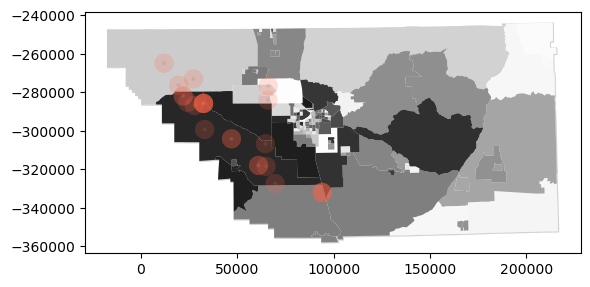

In [207]:
fig, ax = plt.subplots()
kern.plot(ax=ax, color='white', edgecolor="lightgrey", legend=True)
kern_socialdata.plot(ax=ax, cmap='Greys', legend=True)
result['geom_buff1000'].plot(ax = ax, facecolors='none', color="grey", alpha=.2, markersize=1)
result['geom_buff5000'].plot(ax = ax, facecolors='none', color="tomato", alpha=.2, markersize=1)